# Fitting Curves

There are many reasons one may want to fit their SMPS/OPS/OPC data; here, we briefly show how you can use `py-smps` to do so. 

Currently, `py-smps` supports simultaneous fitting of 1-3 modes at a time. If you need more than that, try fitting them separately or open an issue with a suggestion on how to do so.

In [1]:
import smps
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set("notebook", style='ticks', font_scale=1.25, palette='colorblind')
smps.set()

## Fit a single mode

Below, we will use the *Boston* example dataset to complete this tutorial. While you *can* use this tool to fit data from optical instruments, it may be practically difficult to converge on a solution if working in a number-weighted space where there is no peak in the distribution. If you have specific questions about implementation, please feel free to post on the discussions board on GitHub.

Let's begin by loading the data and plotting the distribution.

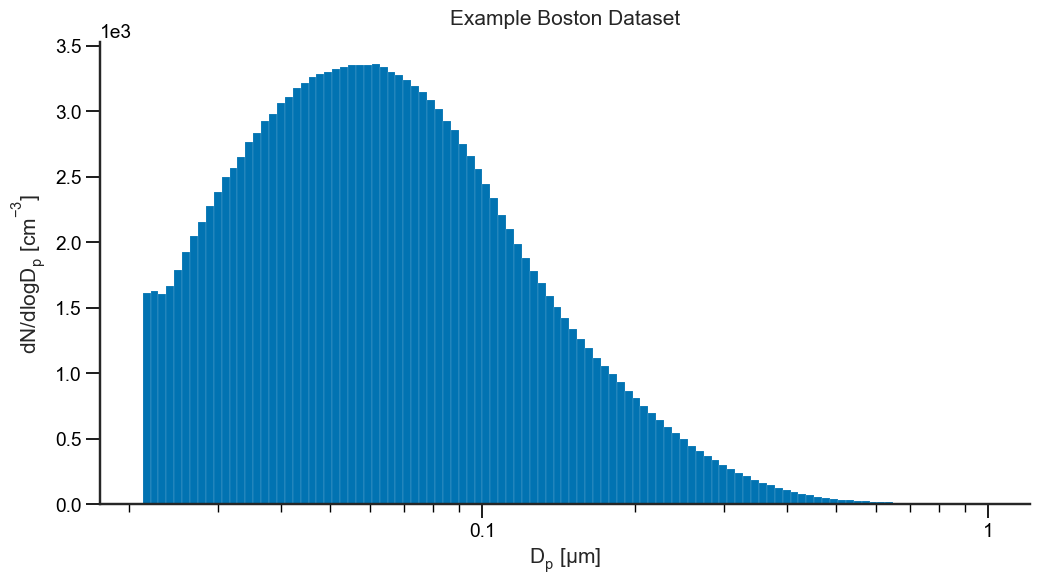

In [2]:
obj = smps.io.load_sample("boston")

# Plot the histogram
ax = smps.plots.histplot(
    obj.dndlogdp,
    obj.bins,
    plot_kws=dict(linewidth=0.1),
    fig_kws=dict(figsize=(12, 6))
)

ax.set_title("Example Boston Dataset", y=1.02)
ax.set_ylabel("$dN/dlogD_p \; [cm^{-3}]$")

sns.despine()

Above, we plotted the particle size distribution and can see that during this time, there was a single dominant mode with a mode particle diameter of approximately 50-60 nm. Next, we can use the `LogNormal` class to fit a simple single-mode distribution to our data:

In [3]:
from smps.fit import LogNormal

# Initialize the class
model = LogNormal()

# Gather our X and Y values
X = obj.midpoints
Y = obj.dndlogdp.mean()

# Fit the data
results = model.fit(X, Y, modes=1)

# Print out the results
results.summary()

                              LogNormalFitResults                               
                          N (cm-3)            GM (nm)               GSD         
--------------------------------------------------------------------------------
       Mode 0        2.73e+03 (7.3e+00)   56.07 (1.2e-01)      2.10 (5.2e-03)   
--------------------------------------------------------------------------------

Above, we see the results printed out as a table with the three fit parameters (and error estimates):

  * `N`, the number concentration in particles per cubic centimeter
  * `GM`: the geometric mean diameter in nm
  * `GSD`: the geometric standard deviation

All three parameters have error estimates as well (standard deviation) as shown in the parens. Now that we've successfully fit our data, we can go ahead and plot it to make sure the fit was successful.

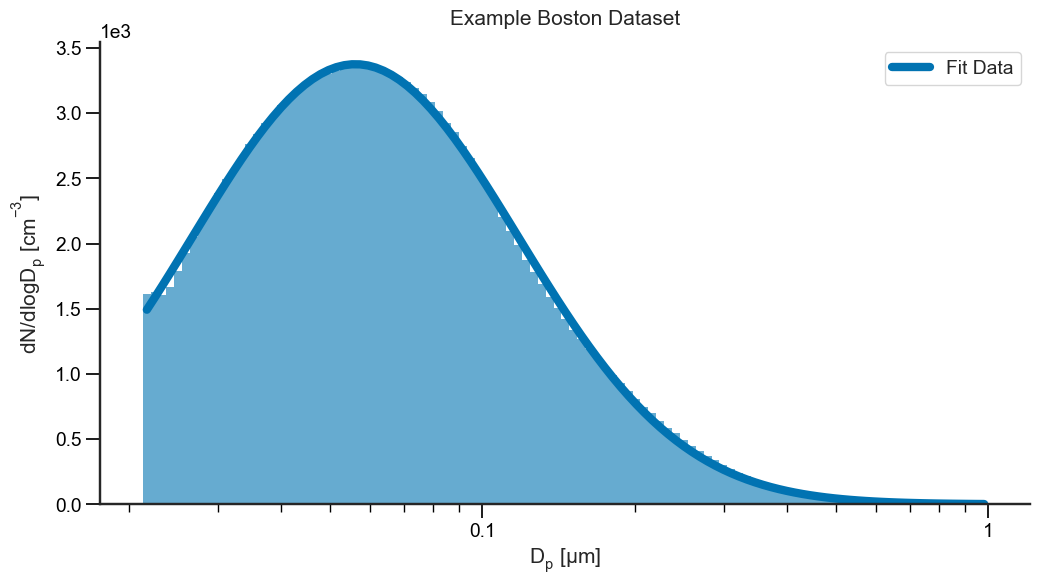

In [4]:
ax = smps.plots.histplot(
    obj.dndlogdp,
    obj.bins,
    plot_kws=dict(linewidth=0, alpha=.6, edgecolor=None),
    fig_kws=dict(figsize=(12, 6))
)

# Plot the fit values
ax.plot(obj.midpoints, results.fittedvalues, lw=6, label="Fit Data")

# Adjust the labels
ax.set_title("Example Boston Dataset", y=1.02)
ax.set_ylabel("$dN/dlogD_p \; [cm^{-3}]$")
ax.legend()

sns.despine()

So, what else is stored alongside the `fittedvalues` in the fit results? Glad you asked! For beginners, you can go ahead and pull the fit parameters using `results['params']`. They are stored in format `[N, GM, GSD]`.

In [5]:
results.params

array([[2.73066908e+03, 5.60740983e-02, 2.10235550e+00]])

You can also go ahead and pull the error estimates for each of those values:

In [6]:
results.errors

array([[7.30970575e+00, 1.23588578e-04, 5.17954871e-03]])

Upon fitting, an instance of the `LogNormalFitResults` class is returned and has available a couple of useful methods. The first is the `summary` method that we shows above which prints out a nice table of results. There is also a `predict` method that allows you to predict the number concentration at any diameter using the fit model.

In [7]:
# Compute the number concentration at 1 µm
results.predict(1.)

1.8359080004552346

### Plot missing data

We can use this `predict` method to fill in/interpolate the lower missing portion of the distribution where we have no data.

<div class="alert alert-info">

Note

You should first consult your science knowledge before deciding to interpolate or extrapolate data as it may not be scientifically valid. For example, if we only have data down to 100 nm, there may be an entire other mode below that which we can't possibly extrapolate. Nonetheless, this can be a useful approach for filling in data gaps.

</div>

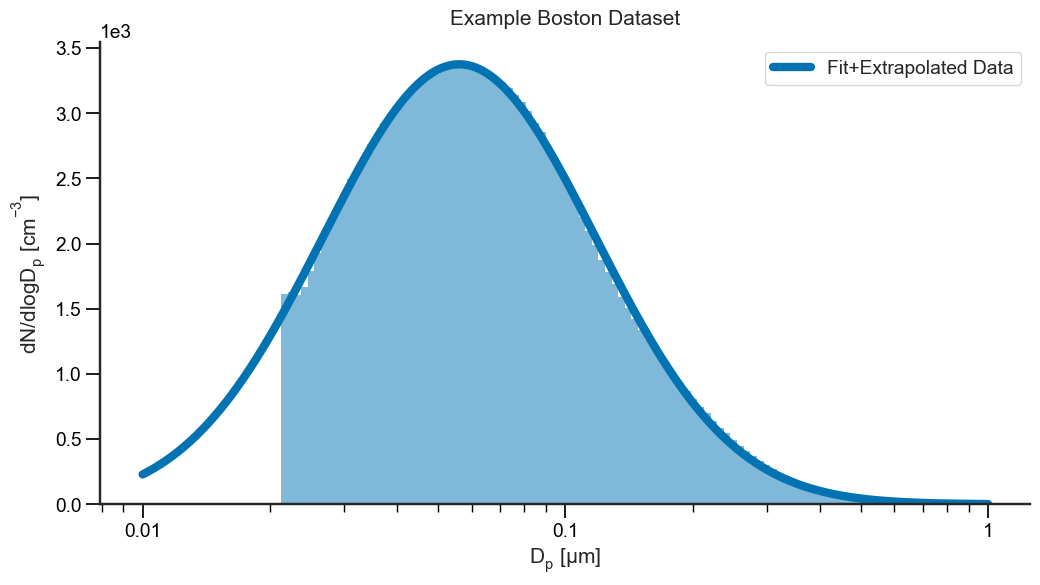

In [8]:
# Create a new array of x values
new_x = np.logspace(np.log10(0.01), np.log10(1), 1000)

# Plot the histogram
ax = smps.plots.histplot(
    obj.dndlogdp, 
    obj.bins,
    plot_kws=dict(linewidth=0, alpha=0.5),
    fig_kws=dict(figsize=(12, 6))
)

# Plot the missing data
ax.plot(new_x, results.predict(new_x), lw=6, label="Fit+Extrapolated Data")

# Adjust the labels
ax.set_title("Example Boston Dataset", y=1.02)
ax.set_ylabel("$dN/dlogD_p \; [cm^{-3}]$")
ax.legend()

sns.despine()

## Fit multiple modes

While the existing sample data set doesn't have a strong multi-mode period, we can mock the data to show the utility of `py-smps`. 

<div class="alert alert-warning">

Data Request

If you are in possession of, and willing to donate, a dataset that *does* have a good multi-mode example, we would love to hear from you! Please open a ticket on GitHub and let us know!

</div>

First, let's mock up a noisy, multi-mode dataset:

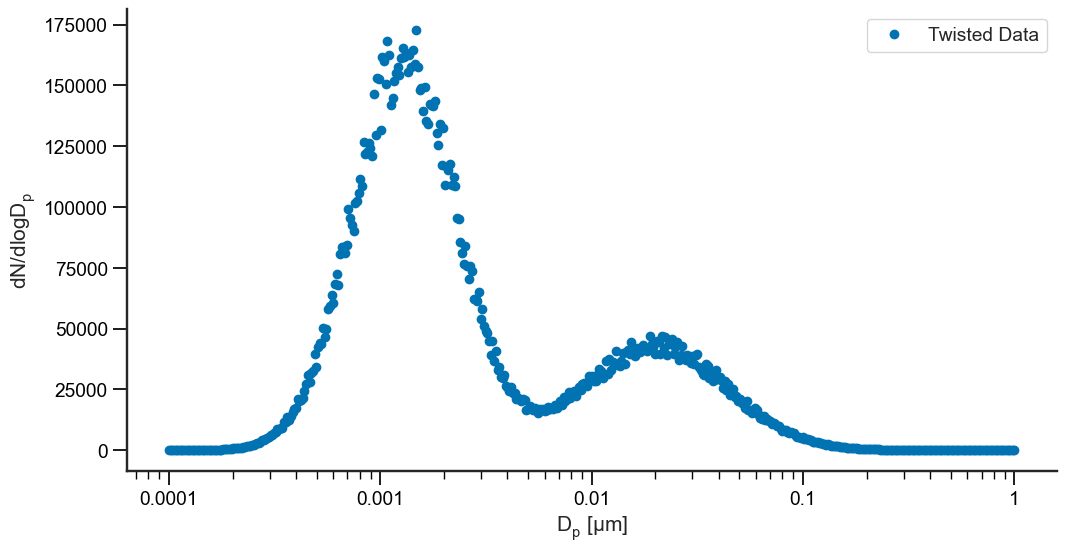

In [9]:
dp = np.logspace(np.log10(1e-4), np.log10(1), 500)

# Set sample N, GM, and GSD from Seinfeld and Pandis
N = [9.93e4, 3.64e4]
GM = [1.3e-3, 20e-3]
GSD = [10**.245, 10**.336]

total = 0
for j in range(len(N)):
    total += smps.fit.dndlogdp(dp, N[j], GM[j], GSD[j])

# Let's confuzzle our data a bit
twisted = total * np.random.uniform(0.9, 1.1, len(dp))

fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(dp, twisted, 'o', label="Twisted Data")
ax.set_xlabel("$D_p \; [\mu m]$")
ax.set_ylabel("$dN/dlogD_p$")
ax.semilogx()

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.4g"))
ax.legend()

sns.despine()
plt.show()

Now that we have some mocked data, let's go ahead and fit it! We're also going to need to throw some initial guesses at it - there need to be 3xn guesses where n is the number of modes we are trying to fit. They should be in the format `[N, GM, GSD]` for each mode:


In [10]:
model = smps.fit.LogNormal()

X = dp
Y = twisted

# Let's set our initial guesses for 2 modes
p0 = [1e5, 1e-3, 2, 3e4, 20e-3, 2]

# Fit the model
results = model.fit(X, Y, modes=2, p0=p0)

# Print the results
results.summary()

                              LogNormalFitResults                               
                          N (cm-3)            GM (nm)               GSD         
--------------------------------------------------------------------------------
       Mode 0        9.90e+04 (3.3e+02)    1.30 (2.8e-03)      1.76 (3.9e-03)   
       Mode 1        3.61e+04 (3.9e+02)   19.99 (1.9e-01)      2.16 (2.1e-02)   
--------------------------------------------------------------------------------

These results are pretty close to what we set up the problem with! Not bad! Now, let's go ahead and visualize it to make sure our results hold up:

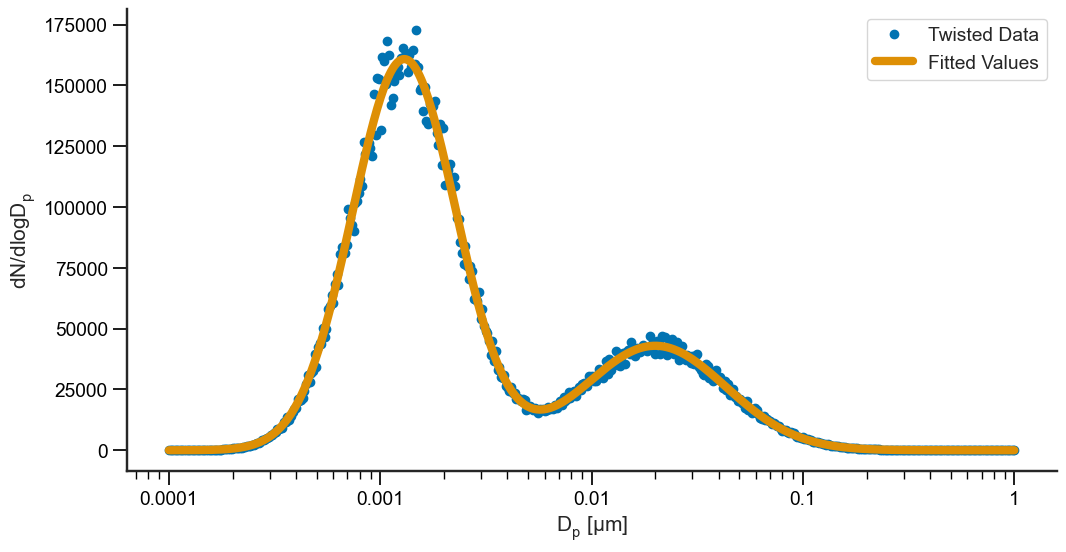

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 6))

# Plot the data
ax.plot(dp, twisted, 'o', label="Twisted Data")
ax.plot(dp, results.fittedvalues, lw=6, label="Fitted Values")

# Fix the labels
ax.set_xlabel("$D_p \; [\mu m]$")
ax.set_ylabel("$dN/dlogD_p$")
ax.semilogx()

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.4g"))
ax.legend()
sns.despine()

Nice! Now, what if we have a dataset like above, but we only want to fit a portion of it? No problem! We can fit just 1 mode between two diameters of our choosing:

                              LogNormalFitResults                               
                          N (cm-3)            GM (nm)               GSD         
--------------------------------------------------------------------------------
       Mode 0        1.01e+05 (1.8e+03)    1.31 (1.5e-02)      1.80 (2.1e-02)   
--------------------------------------------------------------------------------

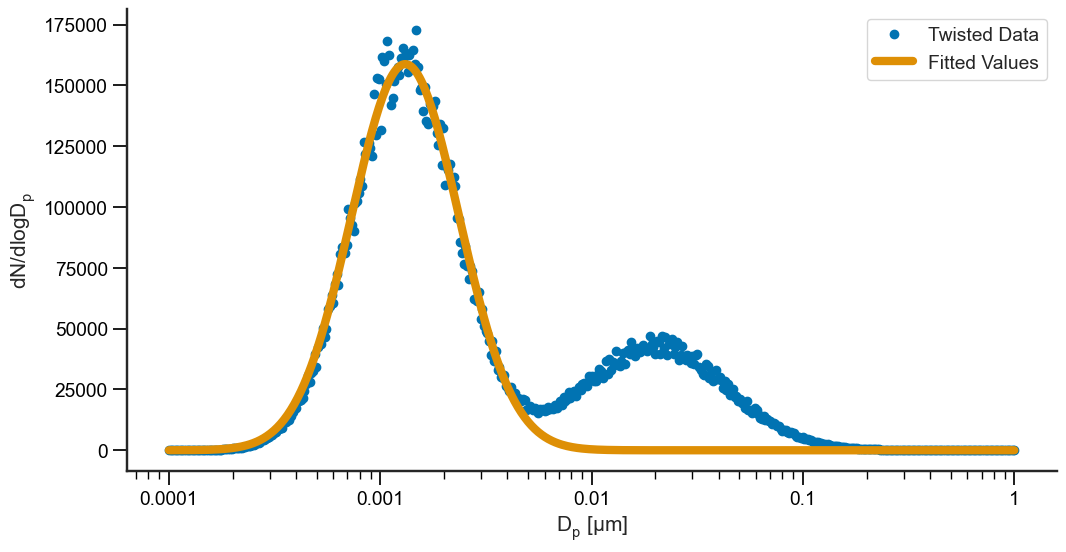

In [12]:
model = smps.fit.LogNormal()

X = dp
Y = twisted

# Fit the model between 0 and 20 nm
results = model.fit(X, Y, modes=1, xmin=0, xmax=20)


fig, ax = plt.subplots(1, figsize=(12, 6))

# Plot the data
ax.plot(dp, twisted, 'o', label="Twisted Data")
ax.plot(X[X <= 8.5], results.fittedvalues, lw=6, label="Fitted Values")

# Adjust the labels
ax.set_xlabel("$D_p \; [\mu m]$")
ax.set_ylabel("$dN/dlogD_p$")
ax.semilogx()

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.4g"))
ax.legend()

sns.despine()

# Print the summary results
results.summary()